In [1]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# Comment out if running from local environment
!pip install --upgrade git+https://github.com/google-deepmind/nuclease_design.git

# Imports

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from nuclease_design import plotting
from nuclease_design import utils


# Load data

In [4]:
df = utils.load_landscape()

In [5]:
assert df['sequence'].is_unique

In [6]:
df['activity_level'] = (
    df['activity_level'].str.replace('_greater_than_', ' > ')
)

In [7]:
eppcr_df = df[df['sublibrary_names'].apply(lambda names: 'g1_eppcr' in names)]

In [8]:
df.activity_level.value_counts()

activity_level
non-functional     33890
activity > 0       11099
activity > WT      10572
activity > A73R      199
Name: count, dtype: int64

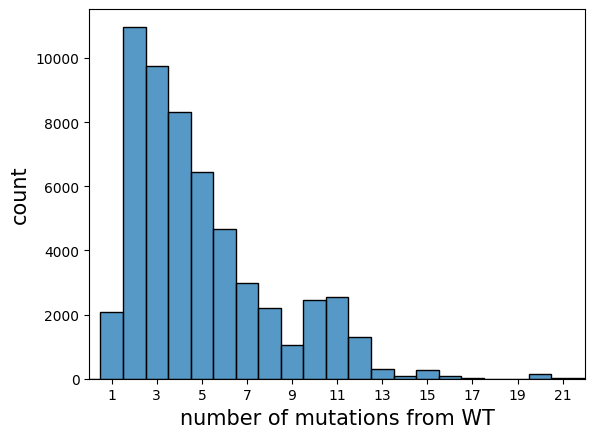

In [9]:
sns.histplot(df['num_mutations'], discrete=True)
plt.xlabel('number of mutations from WT', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.xlim(left=0, right=22)
_ = plt.xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])

In [10]:
def make_histplot(df):
  sns.histplot(
      data=df,
      x='num_mutations',
      hue='activity_level',
      multiple='stack',
      discrete=True,
      hue_order=[
          'activity > A73R',
          'activity > WT',
          'activity > 0',
          'non-functional',
      ],
      palette=sns.color_palette("cubehelix", n_colors=4),
  )
  plt.xlim(left=0, right=13.5)
  plt.xlabel('Number of mutations')
  plotting.set_fontsize(plt.gca(), 15)

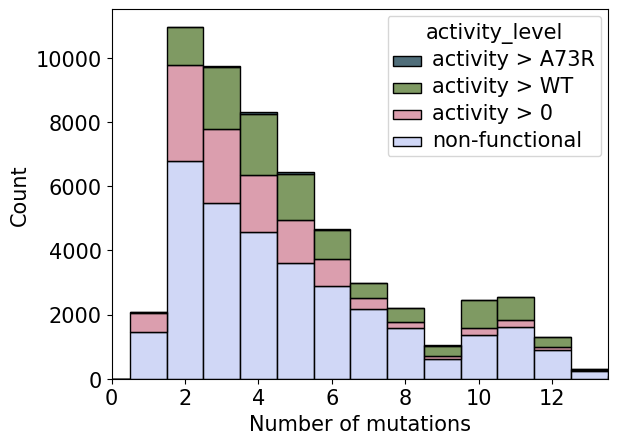

In [11]:
make_histplot(df)

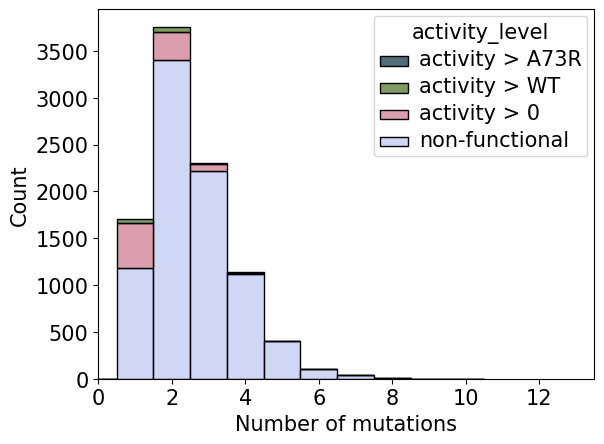

In [12]:
make_histplot(eppcr_df)

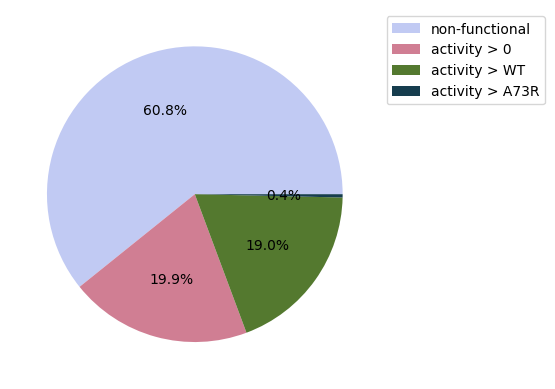

In [13]:
def make_pie_chart(df):
  hue_order = [
      'non-functional',
      'activity > 0',
      'activity > WT',
      'activity > A73R',
  ]
  hue_order = [hue for hue in hue_order if hue in df['activity_level'].unique()]
  label_counts = df['activity_level'].value_counts()[hue_order]
  patches = plt.pie(
      label_counts.values,
      autopct='%1.1f%%',
      colors=sns.color_palette('cubehelix_r', n_colors=4),
  )
  plt.legend(labels=label_counts.index, bbox_to_anchor=(1, 1))



make_pie_chart(df)

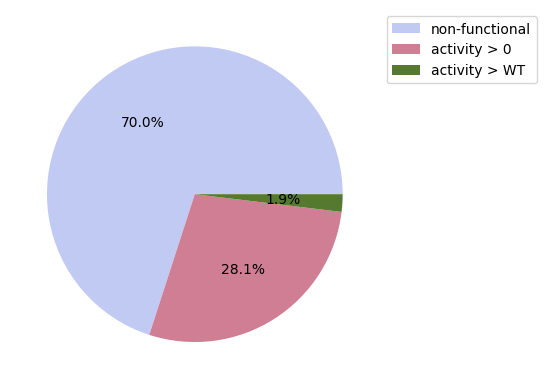

In [14]:
make_pie_chart(df[df['num_mutations'] == 1])

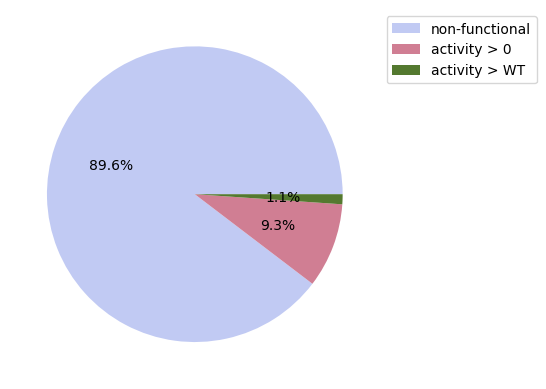

In [15]:
make_pie_chart(eppcr_df)

In [16]:
d = df[df['num_mutations'] == 4]
num = d['is_functional'].sum()
denom = len(d)
print(f'{num / denom} ({num} / {denom})')

0.45134550696780396 (3757 / 8324)


In [17]:
d = eppcr_df[eppcr_df['num_mutations'] == 4]
num = eppcr_df['is_functional'].sum()
denom = len(eppcr_df)
print(f'{num / denom} ({num} / {denom})')

0.10359072132189387 (978 / 9441)


# Epistasis

In [18]:
ssm_df = df[df['num_mutations'] == 1].copy()
ssm_df['mutation'] = ssm_df['mutations'].apply(lambda s: s[0])
ssm_mut_dict = ssm_df.set_index('mutation')['is_functional'].to_dict()


In [19]:
# impact of individual mutations
pd.Series(ssm_mut_dict.values()).value_counts()

False    1462
True      626
Name: count, dtype: int64

In [20]:
def analyze_epistasis(df, ssm_mut_dict):
  df = df[(df['num_mutations'] > 1) & (df['mutations'].apply(lambda muts: all(m in ssm_mut_dict for m in muts)))].copy()

  df['ssm_labels'] = df['mutations'].apply(lambda muts: [ssm_mut_dict[m] for m in muts])
  pos_ssm = df['ssm_labels'].apply(all)
  denominator = pos_ssm.sum()
  numerator = denominator -  df[pos_ssm]['is_functional'].sum()
  print(f'negative epistasis rate: {numerator / denominator} ({numerator} of {denominator})')

  neg_ssm = ~df['ssm_labels'].apply(any)
  denominator = neg_ssm.sum()
  numerator = df[neg_ssm]['is_functional'].sum()
  print(f'positive epistasis rate: {numerator / denominator} ({numerator} of {denominator})')

analyze_epistasis(df[df['num_mutations'] == 2], ssm_mut_dict)

negative epistasis rate: 0.19995471014492755 (883 of 4416)
positive epistasis rate: 0.01638672675133142 (40 of 2441)


In [21]:
analyze_epistasis(eppcr_df[eppcr_df['num_mutations'] == 2], ssm_mut_dict)

negative epistasis rate: 0.4923469387755102 (193 of 392)
positive epistasis rate: 0.011370436864153202 (19 of 1671)


In [22]:
zero_shot_df = df[df['sublibrary_names'].apply(lambda names: 'zero_shot' in names)]
analyze_epistasis(zero_shot_df[zero_shot_df['num_mutations'] == 2], ssm_mut_dict)

negative epistasis rate: 0.27071823204419887 (49 of 181)
positive epistasis rate: 0.14285714285714285 (1 of 7)


In [23]:
analyze_epistasis(df, ssm_mut_dict)

negative epistasis rate: 0.281489330957083 (5844 of 20761)
positive epistasis rate: 0.012979989183342347 (48 of 3698)
